Script to plot QVA deterministic concentration field with the colors aggreed per threshold:

| Threshold | Color                 |
|-----------|-----------------------|
| [0.2 - 2[ | [160,210,255], # blue |
| [2 - 5[   | [255,153,0], # orange |
| [5 - 10[  | [255,40,0], # red     |
| >= 10     | [170,0,170], # purple |


In [23]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cf

from math import floor,ceil

xlocs = [100,110, 120, 130, 140, 150, 160, 170, 179.99999, -170, -160, -150, -140, -130, -120, -110, -100]
clon = 180
bnd = [160,200,-50,-30]
almost_zero = 1e-16


# Colormap settings

[ 0.2  2.   5.  10. ]
['#a0d2ff', '#ff9900', '#ff2800', '#aa00aa']


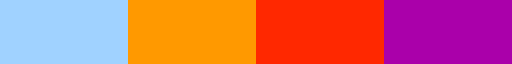

In [2]:
thresholds = np.array([0.2,2,5,10])
print(thresholds)

colors_rgb= [
    [160,210,255], # blue
    [255,153,0], # orange
    [255,40,0], # red
    [170,0,170], # purple
]
colors = [mpl.colors.to_hex(np.array(rgb)/255) for rgb in colors_rgb]
print(colors )

cmap = mpl.colors.ListedColormap(colors)
cmap 

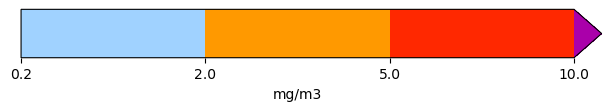

In [3]:
# without the `extend=max` option, the colorbar will not show the color for the pre-to-last value (red)

norm=mpl.colors.BoundaryNorm(thresholds,cmap.N, extend='max')

fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             cax=ax, orientation='horizontal', label='mg/m3')#, boundaries=thresholds, ticks=thresholds)


# Read QVA deterministic netcdf file

In [5]:
ds = xr.open_dataset('../202501_QVA_Exercise/qva_det_Ruapehu_202501081200.nc')
ds

<xarray.Dataset> Size: 183MB
Dimensions:        (latitude: 361, longitude: 441, levels: 12, time: 24)
Coordinates:
  * latitude       (latitude) float32 1kB -84.28 -84.03 -83.78 ... 5.47 5.72
  * longitude      (longitude) float32 2kB 120.6 120.8 121.1 ... 230.3 230.6
  * levels         (levels) float64 96B 5e+03 1e+04 1.5e+04 ... 5.5e+04 6e+04
  * time           (time) datetime64[ns] 192B 2025-01-08T13:00:00 ... 2025-01...
Data variables:
    concentration  (time, levels, latitude, longitude) float32 183MB ...
Attributes:
    title:                            HYSPLIT Model Concentration Output
    Conventions:                      CF-1.5
    volcano_name:                     Ruapehu
    eruption_lon_degrees:             175.57
    eruption_lat_degrees:             -39.28
    eruption_vent_meters_msl:         2797.0
    eruption_height_meters_msl:       12500.0
    eruption_mass_eruption_rate_kgs:  87500.0
    eruption_start_time:              2025-01-08T12:00:00
    eruption_duration_s:              3600.0

## Full extent of the plume at all levels and times

This helps to zoom into the data and allows to have same zoom in all images.

In [ ]:
# determine full extent of the plume at all levels and times
da = ds['concentration']
da_m = da.where(da > almost_zero, drop=True)
print(f'before mask = {da.shape}')
print(f'after mask  = {da_m.shape}')

bnd = [floor(da_m.longitude.values.min()), ceil(da_m.longitude.values.max()), 
       floor(da_m.latitude.values.min()), ceil(da_m.latitude.values.max())]
print(f'full extent of plume = {bnd}')

before mask = (24, 12, 361, 441)
after mask  = (24, 9, 44, 128)
full extent of data = [174, 207, -40, -29]


## Max concentration at each level

to help us plot interesting stuff

Text(0.5, 1.0, 'Max concentration [mg/m3] at each level')

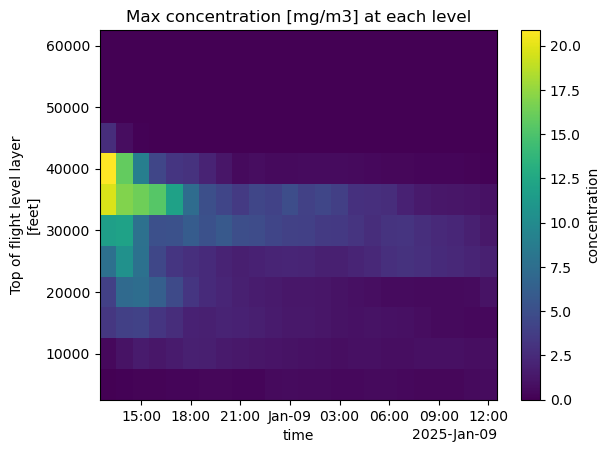

In [6]:
# determine max concentration at each level to help us plot interesting stuff
ds['concentration'].max(dim=('longitude', 'latitude')).plot(y='levels', x='time')
plt.title('Max concentration [mg/m3] at each level')

# Plot deterministic QVA 

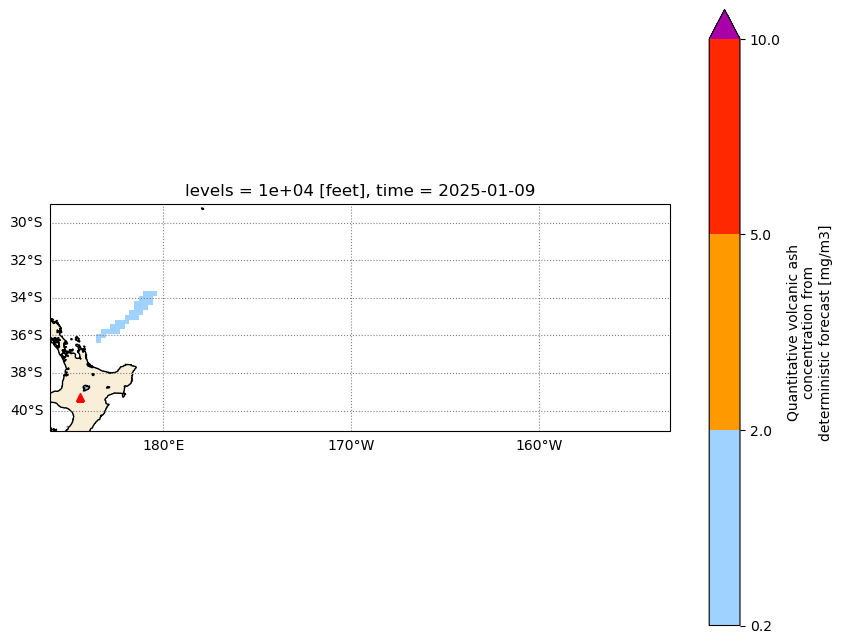

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), subplot_kw={"projection": ccrs.PlateCarree(clon)})

it = 11
k = 1
da = ds['concentration'].isel(time=it, levels=k)

# need to mask to lower thredshold so that the lower limit of colorbar is correct (other C < 0.2 will be blue)
da_m = da.where(da > thresholds[0])

# needs extend max here so that it always plots the colorbar corretly (with purple as the over-color), even if data is lower or all nan
da_m.plot(ax=ax, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), extend='max')

# add volcano location
ax.plot(ds.attrs['eruption_lon_degrees'], ds.attrs['eruption_lat_degrees'], marker='^' , color='r', transform=ccrs.PlateCarree())

# zoom in to see the data
ax.set_extent(bnd)
# ax.set_extent([175, 180, -40, -35])

# add decorations 
# ax.add_feature(cf.OCEAN)
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS, lw=0.5)
ax.add_feature(cf.LAND, edgecolor='black', facecolor='wheat', linewidth=0.5, alpha=0.5)
ax.add_feature(cf.LAKES, edgecolor='black', facecolor=cf.COLORS['water']) #'none')
if clon == 180:
    gl = ax.gridlines(xlocs=xlocs, draw_labels=True, ls=':', color='gray')
else:
    gl = ax.gridlines(draw_labels=True, ls=':', color='gray')

gl.top_labels = False
gl.right_labels = False